# Import

In [1]:
pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2
import shutil
import itertools
import glob
import random

from tensorflow import keras
from tensorflow.keras import layers
from keras.models import load_model
from tensorflow.keras.metrics import MeanIoU
from os import listdir
from os.path import isfile, join
from PIL import Image
from pathlib import Path
from skimage.color import rgb2gray
from keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model

In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K

In [4]:
from numpy.random import seed
seed(1305)
tf.random.set_seed(1305)

In [5]:
from PIL import Image
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
def searching_all_files(directory: Path):   
    file_list = [] # A list for storing files existing in directories

    for x in directory.iterdir():
        if x.is_file():

           file_list.append(str(x))
        else:

           file_list.append(searching_all_files(directory/x))

    return file_list

In [7]:
def flatten(listOfLists):
    "Flatten one level of nesting"
    return list(itertools.chain.from_iterable(listOfLists))

#Parameters


In [8]:
lr = 0.01
n_epochs = 30
n_batch = 16

RESIZE = False
CLAHE = True
OCTA = True
DataAugmentation = True

#Train, val and test

In [9]:
if CLAHE:
  if OCTA:
    if DataAugmentation:
      X_train = np.load('/content/drive/MyDrive/Tesi magistrale/Numpy/Augmented/X_train_augmented_partial_304.npy')
      y_train = np.load('/content/drive/MyDrive/Tesi magistrale/Numpy/Augmented/y_train_augmented_partial_304.npy')
      X_test = np.load('/content/drive/MyDrive/Tesi magistrale/Numpy/Augmented/X_test_augmented_partial_304.npy')
      y_test = np.load('/content/drive/MyDrive/Tesi magistrale/Numpy/Augmented/y_test_augmented_partial_304.npy')
      X_valid = np.load('/content/drive/MyDrive/Tesi magistrale/Numpy/Augmented/X_val_augmented_partial_304.npy')
      y_valid = np.load('/content/drive/MyDrive/Tesi magistrale/Numpy/Augmented/y_val_augmented_partial_304.npy')
    else:
      X_train = np.load('/content/drive/MyDrive/Tesi magistrale/Numpy/X_train_OCTA_CLAHE.npy')
      X_test = np.load('/content/drive/MyDrive/Tesi magistrale/Numpy/X_test_OCTA_CLAHE.npy')
      y_train = np.load('/content/drive/MyDrive/Tesi magistrale/Numpy/y_train.npy')
      y_test = np.load('/content/drive/MyDrive/Tesi magistrale/Numpy/y_test.npy')

  else:  
    X_train = np.load('/content/drive/MyDrive/Tesi magistrale/Numpy/X_train_OCT_CLAHE.npy')
    X_test = np.load('/content/drive/MyDrive/Tesi magistrale/Numpy/X_test_OCT_CLAHE.npy')
    y_train = np.load('/content/drive/MyDrive/Tesi magistrale/Numpy/y_train.npy')
    y_test = np.load('/content/drive/MyDrive/Tesi magistrale/Numpy/y_test.npy')

else:
  X_train = np.load('/content/drive/MyDrive/Tesi magistrale/Numpy/X_train_OCT.npy')
  X_test = np.load('/content/drive/MyDrive/Tesi magistrale/Numpy/X_test_OCT.npy')
  y_train = np.load('/content/drive/MyDrive/Tesi magistrale/Numpy/y_train.npy')
  y_test = np.load('/content/drive/MyDrive/Tesi magistrale/Numpy/y_test.npy')

In [ ]:
#X_train = np.load('/content/drive/MyDrive/Tesi magistrale/Numpy/X_train_OCTA.npy')
#X_test = np.load('/content/drive/MyDrive/Tesi magistrale/Numpy/X_test_OCTA.npy')
#y_train = np.load('/content/drive/MyDrive/Tesi magistrale/Numpy/y_train.npy')
#y_test = np.load('/content/drive/MyDrive/Tesi magistrale/Numpy/y_test.npy')

In [10]:
X_test.shape

(20, 304, 304, 1)

In [ ]:
if DataAugmentation==False:
  X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.10, random_state = 42)

In [11]:
X_train.shape

(1296, 304, 304, 1)

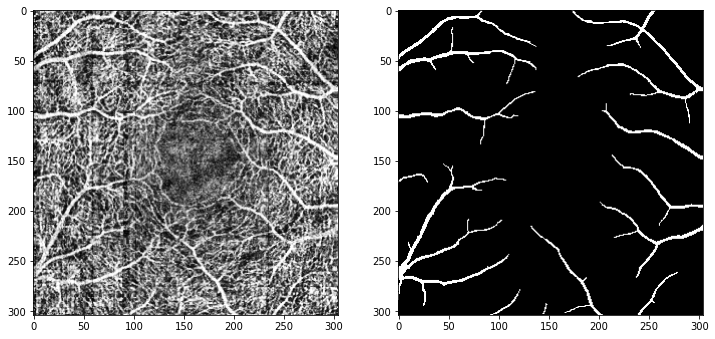

In [12]:
#Sanity check, view few mages
import random

image_number = random.randint(0, len(X_train)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number,:,:,0],cmap = 'gray')
plt.subplot(122)
plt.imshow(y_train[image_number,:,:,0],cmap = 'gray')
plt.show()

#U-Net

In [13]:
def conv_block(x, filter_size, size, dropout, batch_norm=False):
    
    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    return conv

In [14]:
def UNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):
    '''
    UNet, 
    
    '''
    # network structure
    FILTER_NUM = 64 # number of filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    

    inputs = layers.Input(input_shape, dtype=tf.float32)

    # Downsampling layers
    # DownRes 1, convolution + pooling
    conv_128 = conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
   
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, conv_16], axis=3)
    up_conv_16 = conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, conv_32], axis=3)
    up_conv_32 = conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, conv_64], axis=3)
    up_conv_64 = conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
   
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, conv_128], axis=3)
    up_conv_128 = conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
   
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model 
    model = models.Model(inputs, conv_final, name="UNet")
    print(model.summary())
    return model

# Attention U-Net

In [ ]:
def conv_block(x, filter_size, size, dropout, batch_norm=False):
    
    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    return conv

In [ ]:
def repeat_elem(tensor, rep):
    # lambda function to repeat Repeats the elements of a tensor along an axis
    #by a factor of rep.
    # If tensor has shape (None, 256,256,3), lambda will return a tensor of shape 
    #(None, 256,256,6), if specified axis=3 and rep=2.

     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)

def gating_signal(input, out_size, batch_norm=False):
    """
    resize the down layer feature map into the same dimension as the up layer feature map
    using 1x1 conv
    :return: the gating feature map with the same dimension of the up layer feature map
    """
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

# Getting the x signal to the same shape as the gating signal
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

# Getting the gating signal to the same number of filters as the inter_shape
    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])
    #upsample_psi = repeat_elem(upsample_psi, 3)

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn

In [ ]:
def Attention_UNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):
    '''
    Attention UNet, 
    
    '''
    # network structure
    FILTER_NUM = 64 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    
    inputs = layers.Input(input_shape, dtype=tf.float32)

    # Downsampling layers
    # DownRes 1, convolution + pooling
    conv_128 = conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=3)
    up_conv_16 = conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=3)
    up_conv_32 = conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=3)
    up_conv_64 = conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=3)
    up_conv_128 = conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model integration
    model = models.Model(inputs, conv_final, name="Attention_UNet")
    return model

# Attention Residual U-Net

In [ ]:
def conv_block(x, filter_size, size, dropout, batch_norm=False):
    
    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    return conv

In [ ]:
def repeat_elem(tensor, rep):
    # lambda function to repeat Repeats the elements of a tensor along an axis
    #by a factor of rep.
    # If tensor has shape (None, 256,256,3), lambda will return a tensor of shape 
    #(None, 256,256,6), if specified axis=3 and rep=2.

     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)

def gating_signal(input, out_size, batch_norm=False):
    """
    resize the down layer feature map into the same dimension as the up layer feature map
    using 1x1 conv
    :return: the gating feature map with the same dimension of the up layer feature map
    """
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

# Getting the x signal to the same shape as the gating signal
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

# Getting the gating signal to the same number of filters as the inter_shape
    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])
    #upsample_psi = repeat_elem(upsample_psi, 3)

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn

In [ ]:
def res_conv_block(x, filter_size, size, dropout, batch_norm=False):
    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation('relu')(conv)
    
    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    shortcut = layers.Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = layers.BatchNormalization(axis=3)(shortcut)

    res_path = layers.add([shortcut, conv])
    res_path = layers.Activation('relu')(res_path)
    return res_path

In [ ]:
def Attention_ResUNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):
    '''
    Rsidual UNet, with attention 
    
    '''
    # network structure
    FILTER_NUM = 64 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    # input data
    # dimension of the image depth
    inputs = layers.Input(input_shape, dtype=tf.float32)
    axis = 3

    # Downsampling layers
    # DownRes 1, double residual convolution + pooling
    conv_128 = res_conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = res_conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = res_conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = res_conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = res_conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=axis)
    up_conv_16 = res_conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=axis)
    up_conv_32 = res_conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=axis)
    up_conv_64 = res_conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=axis)
    up_conv_128 = res_conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
    
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=axis)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model integration
    model = models.Model(inputs, conv_final, name="AttentionResUNet")
    return model

# Metrics and losses

In [15]:
# Define metrics and losses

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)


def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

# Parameters for model

In [16]:
if RESIZE:
  IMG_HEIGHT = 256
  IMG_WIDTH  = 256  
else:
  IMG_HEIGHT = 304
  IMG_WIDTH  = 304


IMG_CHANNELS = 1
num_labels = 1  #Binary
input_shape = (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)

# Fit U-Net

In [ ]:
'''
UNet
'''

opt = keras.optimizers.Adam(learning_rate=lr)

unet_model = UNet(input_shape)
#unet_model.compile(optimizer=Adam(lr = 1e-2), loss=BinaryFocalLoss(gamma=2), metrics=['accuracy', jacard_coef])

unet_model.compile(optimizer=opt, loss=[jacard_coef_loss], metrics=[jacard_coef])


#print(unet_model.summary())

Model: "UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 304, 304, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 304, 304, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 304, 304, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                              

In [ ]:
#plot_model(unet_model, to_file='unet.png', show_shapes=True)

In [ ]:
unet_history = unet_model.fit(X_train, y_train, 
                    verbose=1,
                    batch_size = n_batch,
                    validation_data=(X_valid, y_valid), 
                    shuffle=True,
                    epochs=n_epochs)

Epoch 1/150
18/18 [==============================] - 36s 743ms/step - loss: -0.1020 - jacard_coef: 0.1020 - val_loss: -0.0116 - val_jacard_coef: 0.0116
Epoch 2/150
18/18 [==============================] - 13s 726ms/step - loss: -0.1261 - jacard_coef: 0.1261 - val_loss: -0.0661 - val_jacard_coef: 0.0661
Epoch 3/150
18/18 [==============================] - 13s 735ms/step - loss: -0.1442 - jacard_coef: 0.1442 - val_loss: -0.0661 - val_jacard_coef: 0.0661
Epoch 4/150
18/18 [==============================] - 13s 741ms/step - loss: -0.1651 - jacard_coef: 0.1651 - val_loss: -0.0024 - val_jacard_coef: 0.0024
Epoch 5/150
18/18 [==============================] - 13s 744ms/step - loss: -0.1894 - jacard_coef: 0.1894 - val_loss: -0.0320 - val_jacard_coef: 0.0320
Epoch 6/150
18/18 [==============================] - 13s 751ms/step - loss: -0.2063 - jacard_coef: 0.2063 - val_loss: -0.0657 - val_jacard_coef: 0.0657
Epoch 7/150
18/18 [==============================] - 14s 757ms/step - loss: -0.2408 - ja

In [ ]:
unet_model.save('/content/drive/MyDrive/Tesi magistrale/modelli_salvati/UNet_v2_OCTA_Augmented_30epoche_LR1e-3_B16_CLAHE.hdf5')

# Fit Attention U-Net

In [ ]:
'''
Attention UNet
'''

opt = keras.optimizers.Adam(learning_rate=lr)

att_unet_model = Attention_UNet(input_shape)

att_unet_model.compile(optimizer=opt, loss=[jacard_coef_loss], metrics=[jacard_coef])


print(att_unet_model.summary())

Model: "Attention_UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 304, 304, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 304, 304, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 304, 304, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                    

In [ ]:
att_unet_history = att_unet_model.fit(X_train, y_train, 
                    verbose=1,
                    batch_size = n_batch,
                    validation_data=(X_valid, y_valid), 
                    shuffle=True,
                    epochs=n_epochs)

Epoch 1/30
162/162 [==============================] - 194s 1s/step - loss: -0.4969 - jacard_coef: 0.4969 - val_loss: -0.2053 - val_jacard_coef: 0.2003
Epoch 2/30
162/162 [==============================] - 159s 981ms/step - loss: -0.6865 - jacard_coef: 0.6865 - val_loss: -0.6789 - val_jacard_coef: 0.6788
Epoch 3/30
162/162 [==============================] - 159s 979ms/step - loss: -0.7102 - jacard_coef: 0.7102 - val_loss: -0.6265 - val_jacard_coef: 0.6277
Epoch 4/30
162/162 [==============================] - 159s 979ms/step - loss: -0.7239 - jacard_coef: 0.7239 - val_loss: -0.7285 - val_jacard_coef: 0.7245
Epoch 5/30
162/162 [==============================] - 158s 977ms/step - loss: -0.7301 - jacard_coef: 0.7301 - val_loss: -0.6917 - val_jacard_coef: 0.6883
Epoch 6/30
162/162 [==============================] - 158s 977ms/step - loss: -0.7367 - jacard_coef: 0.7367 - val_loss: -0.7149 - val_jacard_coef: 0.7147
Epoch 7/30
162/162 [==============================] - 158s 976ms/step - loss: -

In [ ]:
att_unet_model.save('/content/drive/MyDrive/Tesi magistrale/modelli_salvati/AttUNet_v2_OCTA_AugmentedPartial304_30epoche_LR1e-1_B8_CLAHE.hdf5')

# Fit Attention Residual U-Net

In [ ]:
'''
Attention Residual Unet
'''
opt = keras.optimizers.Adam(learning_rate=lr)

att_res_unet_model = Attention_ResUNet(input_shape)

att_res_unet_model.compile(optimizer=opt, loss=[jacard_coef_loss], metrics=[jacard_coef])

print(att_res_unet_model.summary())

Model: "AttentionResUNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 304, 304, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 304, 304, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 304, 304, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                  

In [ ]:
att_res_unet_history = att_res_unet_model.fit(X_train, y_train, 
                    verbose=1,
                    batch_size = n_batch,
                    validation_data=(X_valid, y_valid), 
                    shuffle=True,
                    epochs=n_epochs)

Epoch 1/30
162/162 [==============================] - 221s 1s/step - loss: -0.5203 - jacard_coef: 0.5203 - val_loss: -0.2671 - val_jacard_coef: 0.2604
Epoch 2/30
162/162 [==============================] - 188s 1s/step - loss: -0.6884 - jacard_coef: 0.6884 - val_loss: -0.3086 - val_jacard_coef: 0.3036
Epoch 3/30
162/162 [==============================] - 188s 1s/step - loss: -0.7114 - jacard_coef: 0.7114 - val_loss: -0.6401 - val_jacard_coef: 0.6427
Epoch 4/30
162/162 [==============================] - 187s 1s/step - loss: -0.7252 - jacard_coef: 0.7252 - val_loss: -0.7270 - val_jacard_coef: 0.7254
Epoch 5/30
162/162 [==============================] - 187s 1s/step - loss: -0.7333 - jacard_coef: 0.7333 - val_loss: -0.6997 - val_jacard_coef: 0.6991
Epoch 6/30
162/162 [==============================] - 187s 1s/step - loss: -0.7387 - jacard_coef: 0.7387 - val_loss: -0.6546 - val_jacard_coef: 0.6562
Epoch 7/30
162/162 [==============================] - 187s 1s/step - loss: -0.7435 - jacard_co

In [ ]:
att_res_unet_model.save('/content/drive/MyDrive/Tesi magistrale/modelli_salvati/AttResUNet_v2_OCTA_AugmentedPartial304_30epoche_LR1e-1_B8_CLAHE.hdf5')

#Losses

In [ ]:
'''
# convert the history.history dict to a pandas DataFrame and save as csv for
# future plotting
import pandas as pd    
unet_history_df = pd.DataFrame(unet_history.history) 
#att_unet_history_df = pd.DataFrame(att_unet_history.history) 
#att_res_unet_history_df = pd.DataFrame(att_res_unet_history.history) 

with open('unet_history_df.csv', mode='w') as f:
    unet_history_df.to_csv(f)
  
with open('att_unet_history_df.csv', mode='w') as f:
    att_unet_history_df.to_csv(f)

with open('custom_code_att_res_unet_history_df.csv', mode='w') as f:
    att_res_unet_history_df.to_csv(f)    

#######################################################################
#Check history plots, one model at a time
history = unet_history
#history = att_unet_history
#history = att_res_unet_history

#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['jacard_coef']
#acc = history.history['accuracy']
val_acc = history.history['val_jacard_coef']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Jacard')
plt.plot(epochs, val_acc, 'r', label='Validation Jacard')
plt.title('Training and validation Jacard')
plt.xlabel('Epochs')
plt.ylabel('Jacard')
plt.legend()
plt.show()'''

"\n# convert the history.history dict to a pandas DataFrame and save as csv for\n# future plotting\nimport pandas as pd    \nunet_history_df = pd.DataFrame(unet_history.history) \n#att_unet_history_df = pd.DataFrame(att_unet_history.history) \n#att_res_unet_history_df = pd.DataFrame(att_res_unet_history.history) \n\nwith open('unet_history_df.csv', mode='w') as f:\n    unet_history_df.to_csv(f)\n  \nwith open('att_unet_history_df.csv', mode='w') as f:\n    att_unet_history_df.to_csv(f)\n\nwith open('custom_code_att_res_unet_history_df.csv', mode='w') as f:\n    att_res_unet_history_df.to_csv(f)    \n\n#######################################################################\n#Check history plots, one model at a time\nhistory = unet_history\n#history = att_unet_history\n#history = att_res_unet_history\n\n#plot the training and validation accuracy and loss at each epoch\nloss = history.history['loss']\nval_loss = history.history['val_loss']\nepochs = range(1, len(loss) + 1)\nplt.plot(epoch

In [ ]:
storico = unet_history
#storico = att_unet_history
#storico = att_res_unet_history

loss = storico.history['loss']
val_loss = storico.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(14, 8))
plt.plot(epochs, loss, '#0b747f', label='Training loss')
plt.plot(epochs, val_loss, '#c23631', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
storico = unet_history
#storico = att_unet_history
#storico = att_res_unet_history

loss = storico.history['jacard_coef']
val_loss = storico.history['val_jacard_coef']
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(14, 8))
plt.plot(epochs, loss, '#0b747f', label='Training Jaccard')
plt.plot(epochs, val_loss, '#c23631', label='Validation Jaccard')
plt.title('Training and validation Jaccard')
plt.xlabel('Epochs')
plt.ylabel('Jaccard')
plt.legend()
plt.show()

#Results

In [17]:
model = load_model('/content/drive/MyDrive/Tesi magistrale/modelli_salvati/UNet_v2_OCTA_Augmented_Partial_304_30epoche_LR1e-2_B16_CLAHE.hdf5', compile=False)
#model = unet_model
threshold = 0.5

In [18]:
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > threshold

In [19]:
#____________ MEAN IOU__________________
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.88094807


In [20]:
#_____________ IOU____________________
intersection = np.logical_and(y_test,y_pred_thresholded)
union=np.logical_or(y_test,y_pred_thresholded)
iou_score = np.sum(intersection)/np.sum(union)
print("IoU score is:",iou_score)

IoU score is: 0.7792990940076325


In [21]:
#_____________ DICE____________________
intersection = np.logical_and(y_test,y_pred_thresholded)
union=np.logical_or(y_test,y_pred_thresholded)
dice_score = (2*np.sum(intersection))/(np.sum(union)+np.sum(intersection))
print("Dice score is:", dice_score)

Dice score is: 0.8759618848030387


(1, 304, 304, 1)
(304, 304)


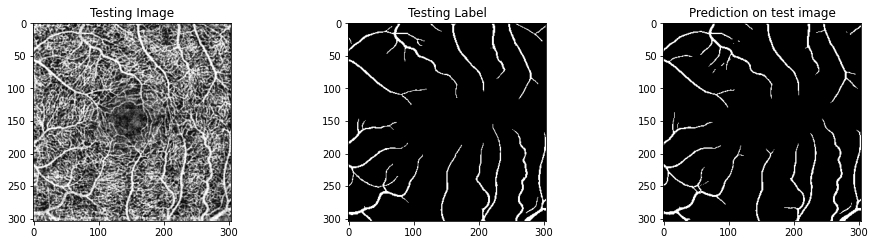

In [22]:
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (model.predict(test_img_input)[0,:,:,0] > threshold).astype(np.uint8)
print(prediction.shape)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

#Overlapping

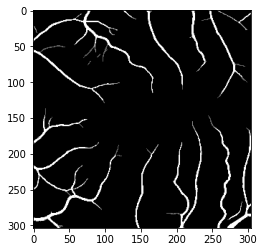

In [24]:
fig, ax = plt.subplots()
ax.imshow(ground_truth[:,:,0], cmap='gray')
ax.imshow(prediction,cmap='gray', alpha=0.4)
fig.show()

# Plot all test images

In [26]:
def plot_images(test_images, ground_truth, prediction, i):
  plt.figure()
  i = i+1
  titolo = 'Testing Image '+str(i)
  plt.title(titolo)
  plt.axis("off")
  plt.imshow(test_img[:,:,0], cmap='gray')
  plt.show()

def plot_overlapping(ground_truth, prediction, i):
  fig, ax = plt.subplots()
  ax.imshow(ground_truth[:,:,0], cmap='gray')
  ax.imshow(prediction,cmap='gray', alpha=0.4)
  i = i+1
  titolo = 'Masks Overlapping '+str(i)
  ax.set_title(titolo)
  plt.axis("off")
  fig.show()

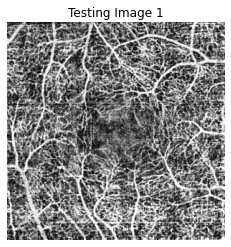

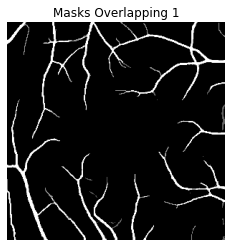

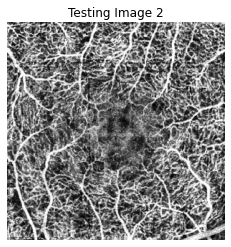

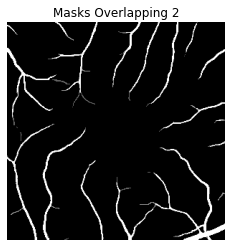

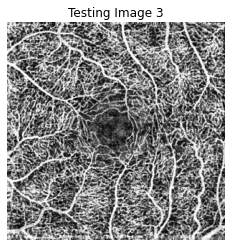

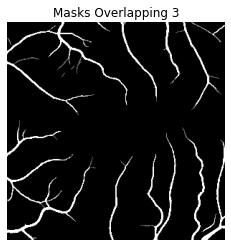

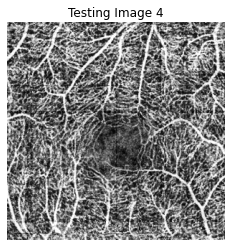

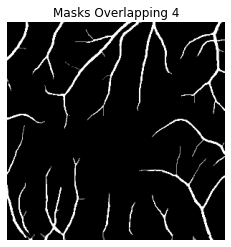

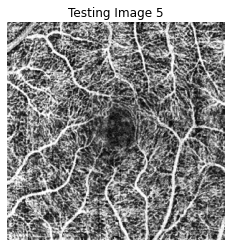

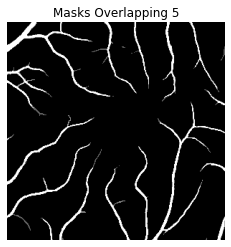

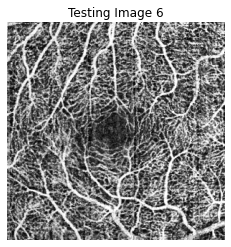

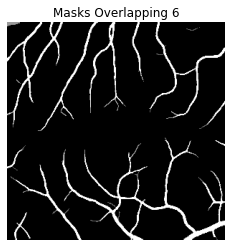

In [27]:
for i in range(len(X_test)): # 6
  test_img_number = i
  test_img = X_test[test_img_number]
  ground_truth=y_test[test_img_number]
  test_img_input=np.expand_dims(test_img, 0)
  prediction = (model.predict(test_img_input)[0,:,:,0] > threshold).astype(np.uint8)
  
  plot_images(test_img, ground_truth, prediction, i)
  plot_overlapping(ground_truth, prediction, i)